In [144]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, classification_report, ConfusionMatrixDisplay
from sklearn.utils import resample
import joblib


In [2]:
def remove_iqr_outliers(df, column):
    Q1 = df[column].quantile(0.20)
    Q3 = df[column].quantile(0.80)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(lower_bound, upper_bound)
    
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    # return df[(df[column] < upper_bound)]

In [103]:
def data_loader(sampling, image_num, distance, features):
    """_summary_

    Args:
        image_num (int): image number to load the corresponding csv file
        distance (float): filter out distance
        features (list): list of features 
    """
    data = pd.read_csv(f'../data/processed/{sampling}/max/STD/Image_{image_num}_max_STD.csv')
    entropy = pd.read_csv(f'../data/processed/{sampling}/max/Entropy/Image_{image_num}_max_Entropy.csv')
    depth = pd.read_csv(f'../data/processed/{sampling}/max/STD/Image_{image_num}_max_STD.csv')
    
    new_df = pd.DataFrame()

    new_df['max_STD'] = data['max_STD']
    new_df['max_Entropy'] = entropy['max_Entropy']
    new_df['depth_value'] = depth['depth_value'] 
    new_df['x'] = depth['x'] 
    new_df['y'] = depth['y'] 
    
    new_df["label"] = np.where(new_df['depth_value'] <= distance, 1, 0)

    max_labels = new_df[new_df.label == 0]
    min_labels = new_df[new_df.label == 1]

    max_down = resample(max_labels,
                        replace=False,
                        n_samples=len(min_labels),     # match minority
                        random_state=42)

    df_balanced = pd.concat([max_down, min_labels])
    
    #print(df_balanced['label'].value_counts())
    
    X = df_balanced[features]
    y = df_balanced['label']
    
    return X, y

In [55]:
# new_df = new_df[(new_df['depth_value'] >= 0.0)&(new_df['depth_value'] <= 0.009)]
# new_df = remove_iqr_outliers(new_df, 'max_STD')
# new_df = new_df[(new_df['max_STD'] >= 0.0)&(new_df['max_STD'] <= 0.07)]
#new_df.head()

,max_STD,max_Entropy,depth_value,x,y,label
0,0.19,2.78,1.64,0,0,0
1,0.18,2.78,1.63,0,1,0
2,0.17,2.69,1.63,0,2,0
3,0.17,2.69,1.63,0,3,0
4,0.17,2.69,1.63,0,4,0


In [ ]:
#sns.scatterplot(x=df_balanced['max_STD'], y=df_balanced['label'])
# sns.boxplot(new_df['max_STD'])
#plt.show()

In [151]:
DIR = "logs"
SAMPLING = "TopDown"
# IMAGE_NUM = 5

# TopDown (Done): 
#          3CM , 5CM, 0.009CM
#          STD, Entropy, (Std, Entropy)

# Circular : 
#          3CM , 5CM, 0.009 CM
#          STD, Entropy, (Std, Entropy)

# FEATURES = ['max_STD']
# FEATURES = ['max_Entropy']
FEATURES = ['max_STD', 'max_Entropy']

DISTANCE = 0.03

feats = "_".join([i.split("_")[-1].upper() for i in FEATURES])
EXP_NAME = feats+"_"+str(DISTANCE)+"_CM"

try:
    if not os.path.isdir(os.path.join("../", DIR, SAMPLING, EXP_NAME)):
        os.mkdir(os.path.join("../",DIR, SAMPLING, EXP_NAME))
except:
    print("Folder Exist")

accuracy_curve = []

for img_num in range(1, 101):
    FOLDER_NAME = "IMAGE_NUM_"+str(img_num)
    if img_num == 100:
        DISTANCE = 0.029
    X, y = data_loader(SAMPLING, img_num, DISTANCE, FEATURES)

    try:
        if not os.path.isdir(os.path.join("../", DIR, SAMPLING, EXP_NAME, FOLDER_NAME)):
            os.mkdir(os.path.join("../",DIR, SAMPLING, EXP_NAME, FOLDER_NAME))
    except:
        print("Folder Exist")
            

    X= X.to_numpy()
    y= y.to_numpy()


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # # # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # # Train MLP Regressor Model
    model = MLPClassifier(hidden_layer_sizes=(16,32), activation='relu', solver='adam', max_iter=2000, random_state=42)

    # model = SVC(kernel="linear", C=0.025, random_state=42)

    # model = SVC(gamma=2, C=1, random_state=42)
    # model = GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42)

    model.fit(X_train_scaled, y_train)

    # clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
    # models,predictions = clf.fit(X_train, X_test, y_train, y_test)
    # models

    # Evaluate model
    print(X_test_scaled)
    sdfsdf
    predictions = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, predictions)
    # print("\nMLP Classification Evaluation:")
    # print(f'accuracy_score: {accuracy:.4f}')
    # print(f'classification_report: {classification_report(y_test, predictions)}')
    # print(f'R^2 Score: {r2_score(y_test, predictions):.4f}')

    with open(os.path.join("../", DIR, SAMPLING, EXP_NAME, FOLDER_NAME, "classification_report.txt"), "a") as f:
        f.write(classification_report(y_test, predictions))
        
    cm = confusion_matrix(y_test, predictions, labels=None)  # labels=None ⇒ inferred
    # print("Confusion matrix (rows = actual, cols = predicted):")
    # print(cm)
    
    joblib.dump(model, os.path.join("../", DIR, SAMPLING, EXP_NAME, FOLDER_NAME, "model.pkl")) 

    # Optional: pretty plotted version
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format='d')          # integer formatting
    plt.title(f"Confusion Matrix - {EXP_NAME}")
    plt.savefig(os.path.join("../", DIR, SAMPLING, EXP_NAME, FOLDER_NAME, "confussion_matrix.png"))
    # plt.show()
    accuracy_curve.append(accuracy)
    
# images = list(range(1, 101))  # 10 epochs

# # Plot
# plt.figure()
# plt.plot(images, accuracy_curve, label='Accuracy Curve')
# plt.xlabel('Image #')
# plt.ylabel('Accuracy')
# plt.title('Accuracy Curve')
# plt.legend()
# plt.grid(True)
# plt.savefig(os.path.join("../", DIR, SAMPLING, EXP_NAME, "accuracy_curve.png"))
# plt.show()

[[-1.22774177e+00 -8.26830796e-01]
 [ 1.36177029e+00 -8.26830796e-01]
 [ 2.92943299e-01 -8.26830796e-01]
 [ 8.12956281e-01 -8.26830796e-01]
 [-1.32994624e+00  8.43772298e-01]
 [ 4.27190046e-01  8.43772298e-01]
 [ 8.30272943e-01  8.43772298e-01]
 [ 6.20309713e-01  8.43772298e-01]
 [ 1.09320147e+00 -8.26830796e-01]
 [ 1.55486307e+00 -8.26830796e-01]
 [ 1.56034177e-01 -8.26830796e-01]
 [-7.87800498e-01 -8.26830796e-01]
 [ 1.71528936e+00  1.72908283e-01]
 [ 5.52928791e-01  8.43772298e-01]
 [ 8.95847468e-01 -8.26830796e-01]
 [-1.34942289e-01  8.43772298e-01]
 [-1.40891997e+00  8.43772298e-01]
 [ 5.97871182e-01 -8.26830796e-01]
 [-7.58974578e-01  8.43772298e-01]
 [-1.80193549e+00 -8.26830796e-01]
 [ 1.31356421e+00  8.43772298e-01]
 [ 3.72225866e-02 -8.26830796e-01]
 [ 7.83165496e-01  2.01122695e+00]
 [ 1.27056866e+00 -8.26830796e-01]
 [ 2.32826927e+00  8.43772298e-01]
 [ 8.68673013e-02 -8.26830796e-01]
 [-2.13516310e+00 -8.26830796e-01]
 [-6.88728174e-01  8.43772298e-01]
 [-7.84949016e-01  8

NameError: name 'sdfsdf' is not defined

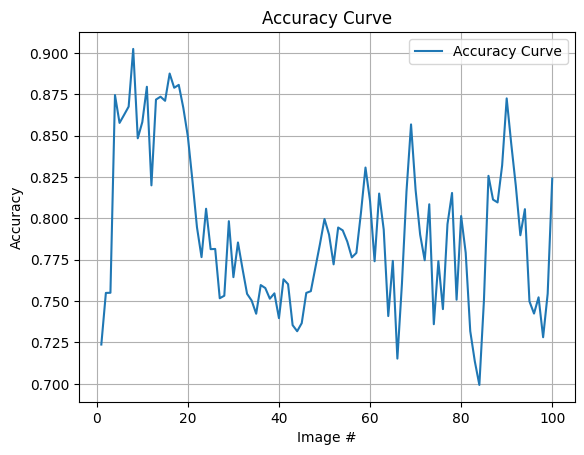

In [150]:
images = list(range(1, 101))  # 10 epochs
np.save(os.path.join("../", DIR, SAMPLING, EXP_NAME, EXP_NAME+"_accuracy_curve.npy"), accuracy_curve)
plt.figure()
# Plot
plt.plot(images, accuracy_curve, label='Accuracy Curve')
plt.xlabel('Image #')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join("../", DIR, SAMPLING, EXP_NAME, "accuracy_curve.png"))
plt.show()

In [148]:
accuracy_avg = np.load('..\logs\TopDown\STD_ENTROPY_0.03_CM\STD_ENTROPY_0.03_CM_accuracy_curve.npy')
np.mean(accuracy_avg)

0.792016603124342